In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from math import pi
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import roc_curve, auc

# Load the dataset
file_path = 'tabula-mvb_stats_2024.csv'
data = pd.read_csv(file_path)

target = "PTS"
features = ["SP", "K", "K/S", "DIG", "DIG/S", "BS", "BA", "BLK", "BLK/S"]

data_cleaned = data[features + [target]].dropna()

lower_bounds = data_cleaned[features].quantile(0.01)
upper_bounds = data_cleaned[features].quantile(0.99)

data_cleaned[features] = data_cleaned[features].clip(lower=lower_bounds, upper=upper_bounds, axis=1)


X = data_cleaned[features].to_numpy()
y = data_cleaned[target].to_numpy()

scaler = RobustScaler()
X_standardized = scaler.fit_transform(X)

print("Are there NaN values in X before preprocessing?", np.isnan(X).any())
print("Are there NaN values in y before preprocessing?", np.isnan(y).any())
print("Are there NaN values in X after preprocessing?", np.isnan(X_standardized).any())

def linear_regression_predict(X, theta):
    return np.dot(X, theta)

def linear_regression_gradient_descent(X, Y, theta, alpha, iterations, clip_value=1e3):
    """
    Performs gradient descent for linear regression with gradient clipping.
    """
    m = len(Y)
    for iter_num in range(iterations):
        predictions = linear_regression_predict(X, theta)
        errors = predictions - Y
        gradients = (1 / m) * np.dot(X.T, errors)

        gradients = np.clip(gradients, -clip_value, clip_value)

        if np.isnan(gradients).any() or np.isinf(gradients).any():
            print(f"Iteration {iter_num}: Invalid gradients detected. Skipping update.")
            break

        theta -= alpha * gradients

    if np.isnan(theta).any() or np.isinf(theta).any():
        print("Invalid theta values detected after gradient descent.")

    return theta

# k-Fold Cross-Validation with Preprocessing in Each Fold
def k_fold_cross_validation_with_selection(X, y, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    mse_scores = []

    for train_idx, test_idx in kf.split(X):

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        scaler = RobustScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        theta = np.zeros(X_train.shape[1])
        theta = linear_regression_gradient_descent(X_train, y_train, theta, alpha=0.01, iterations=1000)

        # Predict and calculate MSE
        y_pred = linear_regression_predict(X_test, theta)
        mse = np.mean((y_pred - y_test) ** 2)
        mse_scores.append(mse)

    return np.mean(mse_scores)

# Bootstrap with .632 Estimator
def bootstrap_632(X, y, n_iterations=100):
    """
    Implements the .632 bootstrap estimator with robust error handling.
    """
    n = len(y)
    mse_in = []
    mse_out = []

    for i in range(n_iterations):
        indices = np.random.choice(range(n), size=n, replace=True)
        X_resampled, y_resampled = X[indices], y[indices]

        mask = np.ones(n, dtype=bool)
        mask[indices] = False
        X_out, y_out = X[mask], y[mask]

        if X_out.shape[0] == 0 or y_out.shape[0] == 0:
            print(f"Iteration {i}: Empty out-of-bag sample. Skipping iteration.")
            continue

        theta = np.zeros(X_resampled.shape[1])
        theta = linear_regression_gradient_descent(X_resampled, y_resampled, theta, alpha=0.01, iterations=1000)

        if np.isnan(theta).any() or np.isinf(theta).any():
            print(f"Iteration {i}: Invalid theta detected. Skipping iteration.")
            continue

        y_pred_in = linear_regression_predict(X_resampled, theta)
        y_pred_out = linear_regression_predict(X_out, theta)

        if np.isnan(y_pred_out).any() or np.isinf(y_pred_out).any():
            print(f"Iteration {i}: Invalid predictions detected. Skipping iteration.")
            continue

        mse_in.append(mean_squared_error(y_resampled, y_pred_in))
        mse_out.append(mean_squared_error(y_out, y_pred_out))

    # Compute .632 bootstrap estimator
    if len(mse_out) == 0:
        print("Error: No valid out-of-bag samples found.")
        return np.nan

    err_in = np.mean(mse_in)
    err_out = np.mean(mse_out)
    err_632 = 0.368 * err_in + 0.632 * err_out
    return err_632

# Perform k-Fold Cross-Validation
kfold_mse = k_fold_cross_validation_with_selection(X_standardized, y, k=5)
print(f"k-Fold Cross-Validation MSE (with proper preprocessing): {kfold_mse:.4f}")

# Perform Bootstrap with .632 estimator
bootstrap_632_mse = bootstrap_632(X_standardized, y, n_iterations=100)
print(f"Bootstrap .632 MSE: {bootstrap_632_mse:.4f}")


Are there NaN values in X before preprocessing? False
Are there NaN values in y before preprocessing? False
Are there NaN values in X after preprocessing? False
k-Fold Cross-Validation MSE (with proper preprocessing): 3231.9376
Bootstrap .632 MSE: 1248.3749


In [2]:
# Model Accuracy
# R² Score
model = LinearRegression()
model.fit(X_standardized, y)

# Predict using the trained model
y_pred = model.predict(X_standardized)

r2 = r2_score(y, y_pred)
print(f"R² Score: {r2:.4f}")

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

R² Score: 0.9995
Mean Absolute Error (MAE): 1.7995


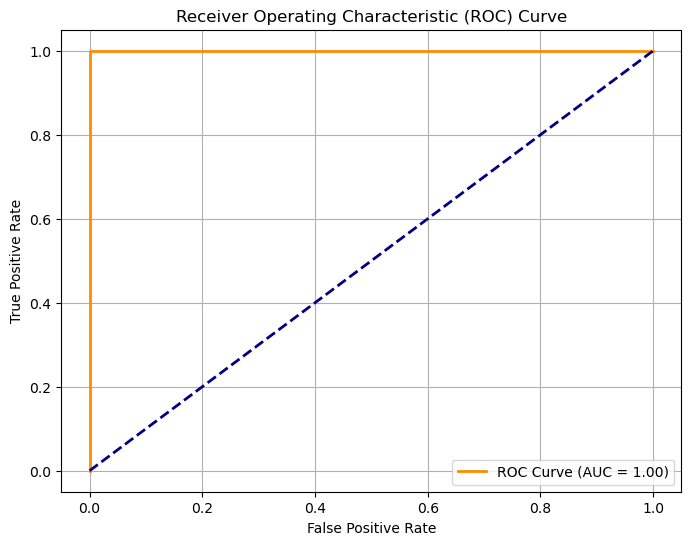

In [3]:
#ROC Curve
threshold = y.mean()
y_binary = (y > threshold).astype(int)
y_pred_binary = (y_pred > threshold).astype(int)

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_binary, y_pred_binary)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--", lw=2)
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


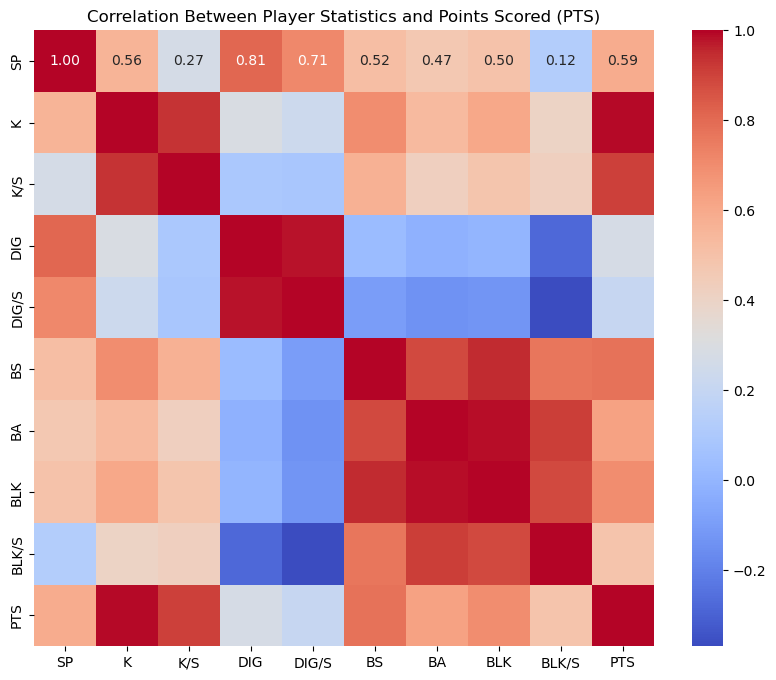

In [4]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = data_cleaned.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Player Statistics and Points Scored (PTS)")
plt.show()


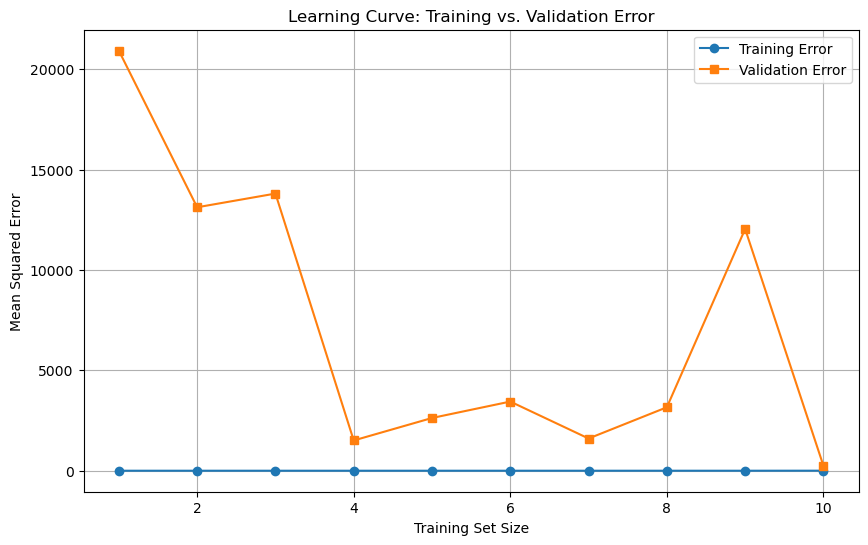

In [5]:

# learning Cruve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=LinearRegression(),
    X=X_standardized,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
)

train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Error", marker='o')
plt.plot(train_sizes, test_mean, label="Validation Error", marker='s')
plt.title("Learning Curve: Training vs. Validation Error")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid()
plt.show()

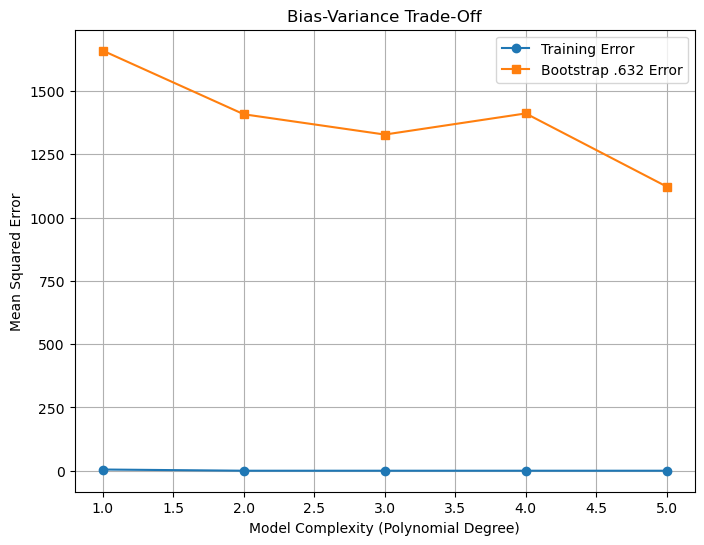

In [6]:
# Bias-variance trade off
degrees = [1, 2, 3, 4, 5]
train_errors, test_errors = [], []

for degree in degrees:
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_standardized, y)

    train_errors.append(mean_squared_error(y, model.predict(X_standardized)))
    test_errors.append(bootstrap_632(X_standardized, y))

plt.figure(figsize=(8, 6))
plt.plot(degrees, train_errors, label="Training Error", marker='o')
plt.plot(degrees, test_errors, label="Bootstrap .632 Error", marker='s')
plt.title("Bias-Variance Trade-Off")
plt.xlabel("Model Complexity (Polynomial Degree)")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid()
plt.show()

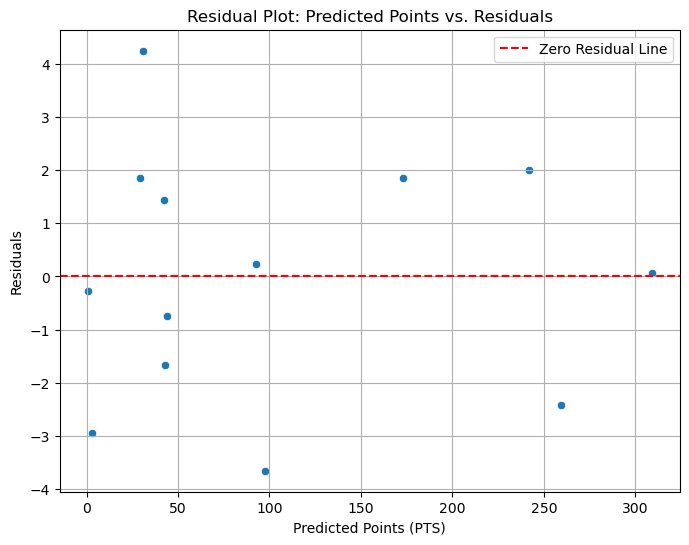

In [7]:
# Residual Plot
model = LinearRegression()
model.fit(X_standardized, y)
y_pred = model.predict(X_standardized)

residuals = y - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, linestyle='--', color='red', label="Zero Residual Line")
plt.title("Residual Plot: Predicted Points vs. Residuals")
plt.xlabel("Predicted Points (PTS)")
plt.ylabel("Residuals")
plt.legend()
plt.grid()
plt.show()

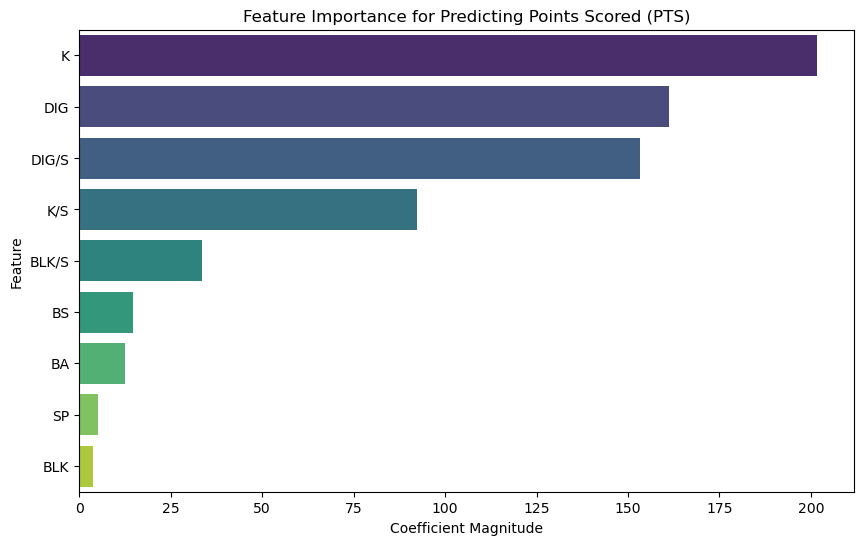

In [8]:

# Feature Importance Visualization
importances = np.abs(model.coef_)
feature_importance = pd.DataFrame({"Feature": features, "Importance": importances})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance, palette="viridis")
plt.title("Feature Importance for Predicting Points Scored (PTS)")
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Feature")
plt.show()

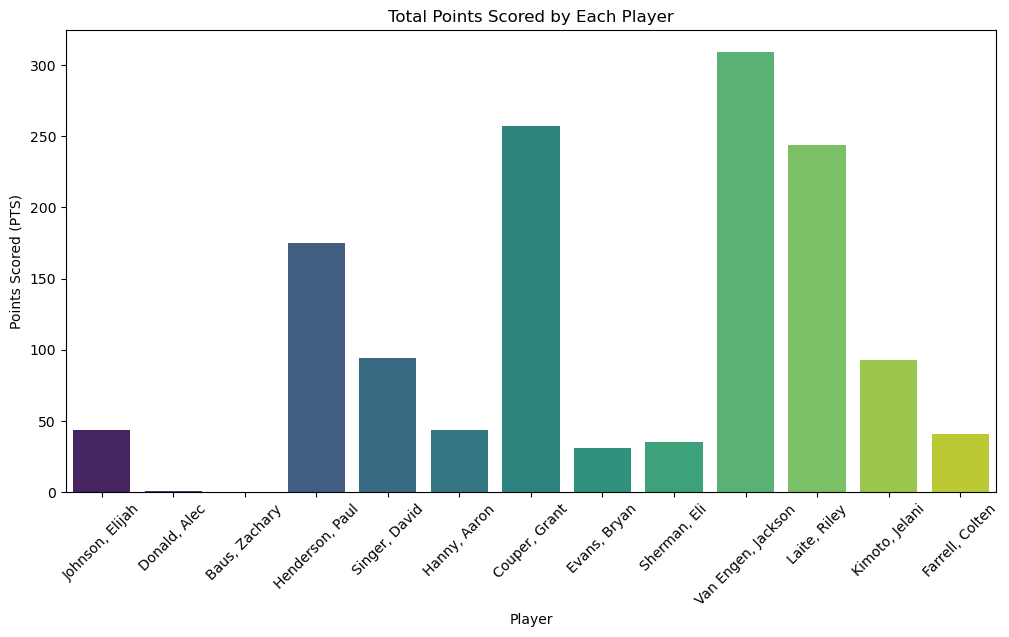

In [9]:
# Bar chart of total points scored by each player
player_names = data['Player'] if 'Player' in data.columns else range(len(data))
points_scored = data_cleaned['PTS']

plt.figure(figsize=(12, 6))
sns.barplot(x=player_names, y=points_scored, palette="viridis")
plt.title("Total Points Scored by Each Player")
plt.xlabel("Player")
plt.ylabel("Points Scored (PTS)")
plt.xticks(rotation=45)
plt.show()

/var/folders/v0/r5w5ydbd3fq8jsrpddtvxkgr0000gn/T/ipykernel_62993/2284169935.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=data_cleaned['K'], y=data_cleaned['PTS'], hue=data_cleaned['Player'] if 'Player' in data_cleaned else None, palette="coolwarm", s=100)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


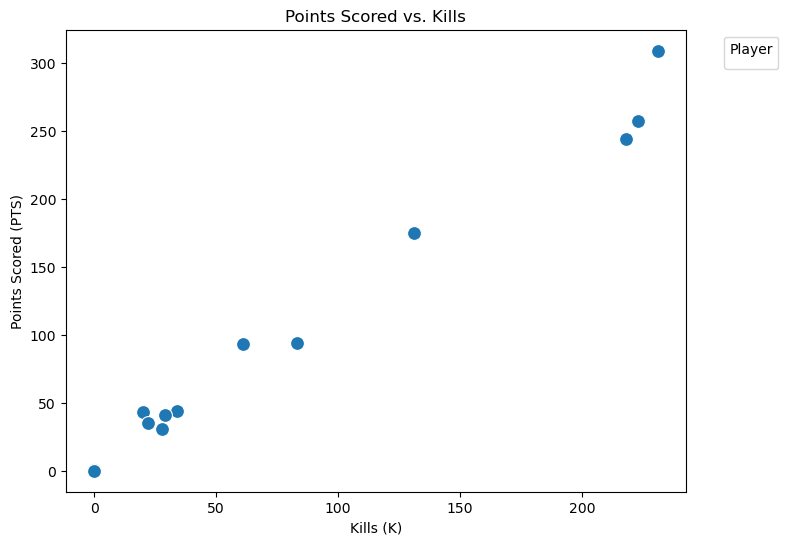

In [10]:
# Scatter Plot: Points Scored vs. Kills
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_cleaned['K'], y=data_cleaned['PTS'], hue=data_cleaned['Player'] if 'Player' in data_cleaned else None, palette="coolwarm", s=100)
plt.title("Points Scored vs. Kills")
plt.xlabel("Kills (K)")
plt.ylabel("Points Scored (PTS)")
plt.legend(title="Player", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


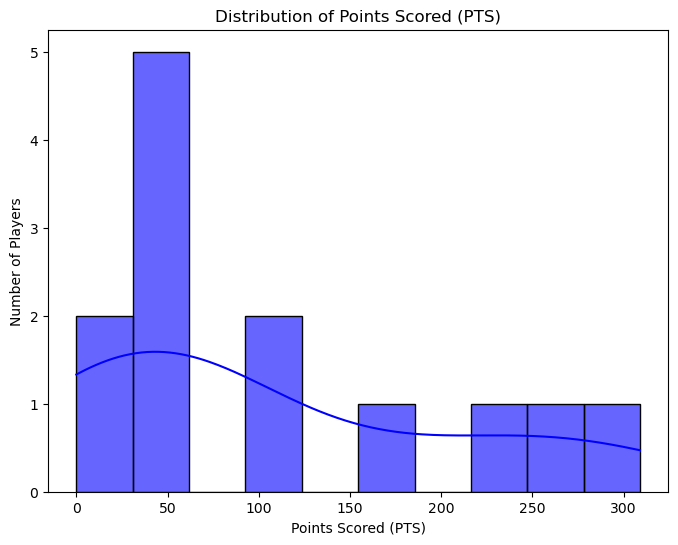

In [11]:
# Distribution of the target variable (PTS)
plt.figure(figsize=(8, 6))
sns.histplot(data_cleaned[target], kde=True, bins=10, color='blue', alpha=0.6)
plt.title("Distribution of Points Scored (PTS)")
plt.xlabel("Points Scored (PTS)")
plt.ylabel("Number of Players")
plt.show()

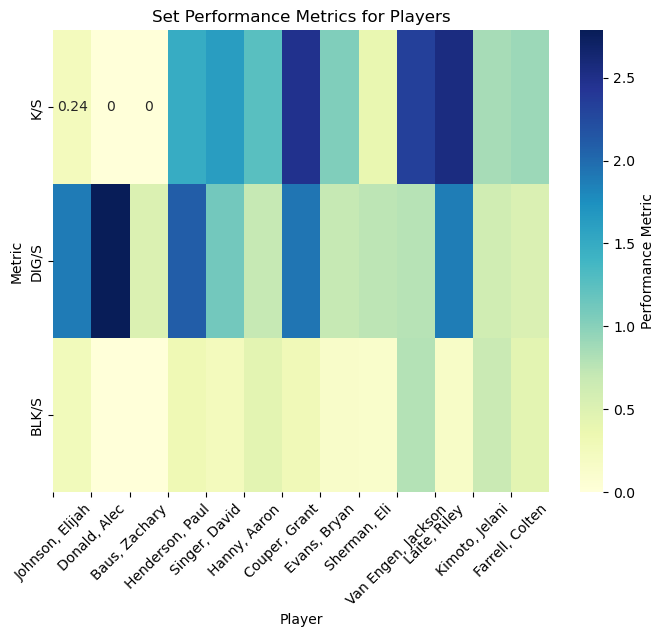

In [38]:
# Heatmap: Set Performance Efficiency (K/S, DIG/S, BLK/S)
set_metrics = ['K/S', 'DIG/S', 'BLK/S']
plt.figure(figsize=(8, 6))
sns.heatmap(data_cleaned[set_metrics].transpose(), annot=True, cmap="YlGnBu", cbar_kws={'label': 'Performance Metric'})
plt.title("Set Performance Metrics for Players")
plt.xlabel("Player")
plt.ylabel("Metric")
plt.xticks(ticks=range(len(data_cleaned)), labels=data['Player'] if 'Player' in data.columns else range(len(data_cleaned)), rotation=45)
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


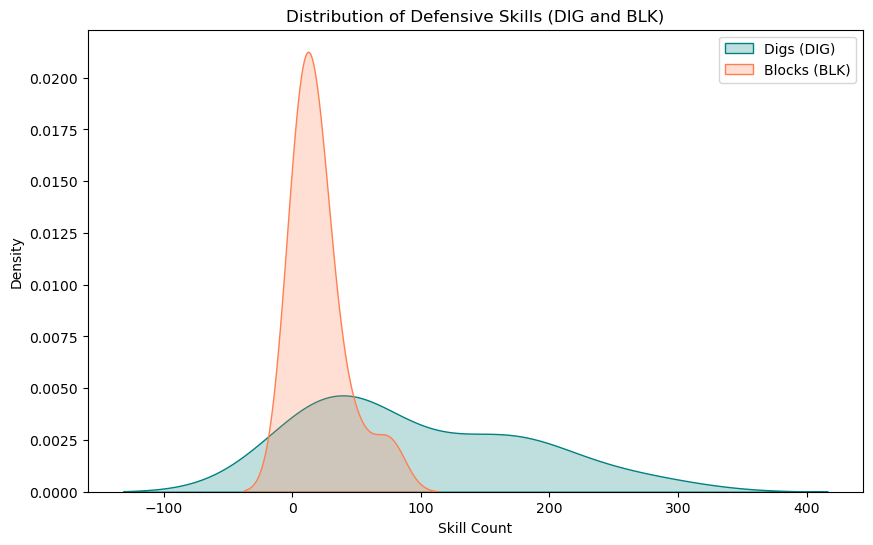

In [13]:
# Distribution of Defensive Skills (DIG and BLK)
plt.figure(figsize=(10, 6))
sns.kdeplot(data_cleaned['DIG'], fill=True, label="Digs (DIG)", color="teal")
sns.kdeplot(data_cleaned['BLK'], fill=True, label="Blocks (BLK)", color="coral")
plt.title("Distribution of Defensive Skills (DIG and BLK)")
plt.xlabel("Skill Count")
plt.ylabel("Density")
plt.legend()
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

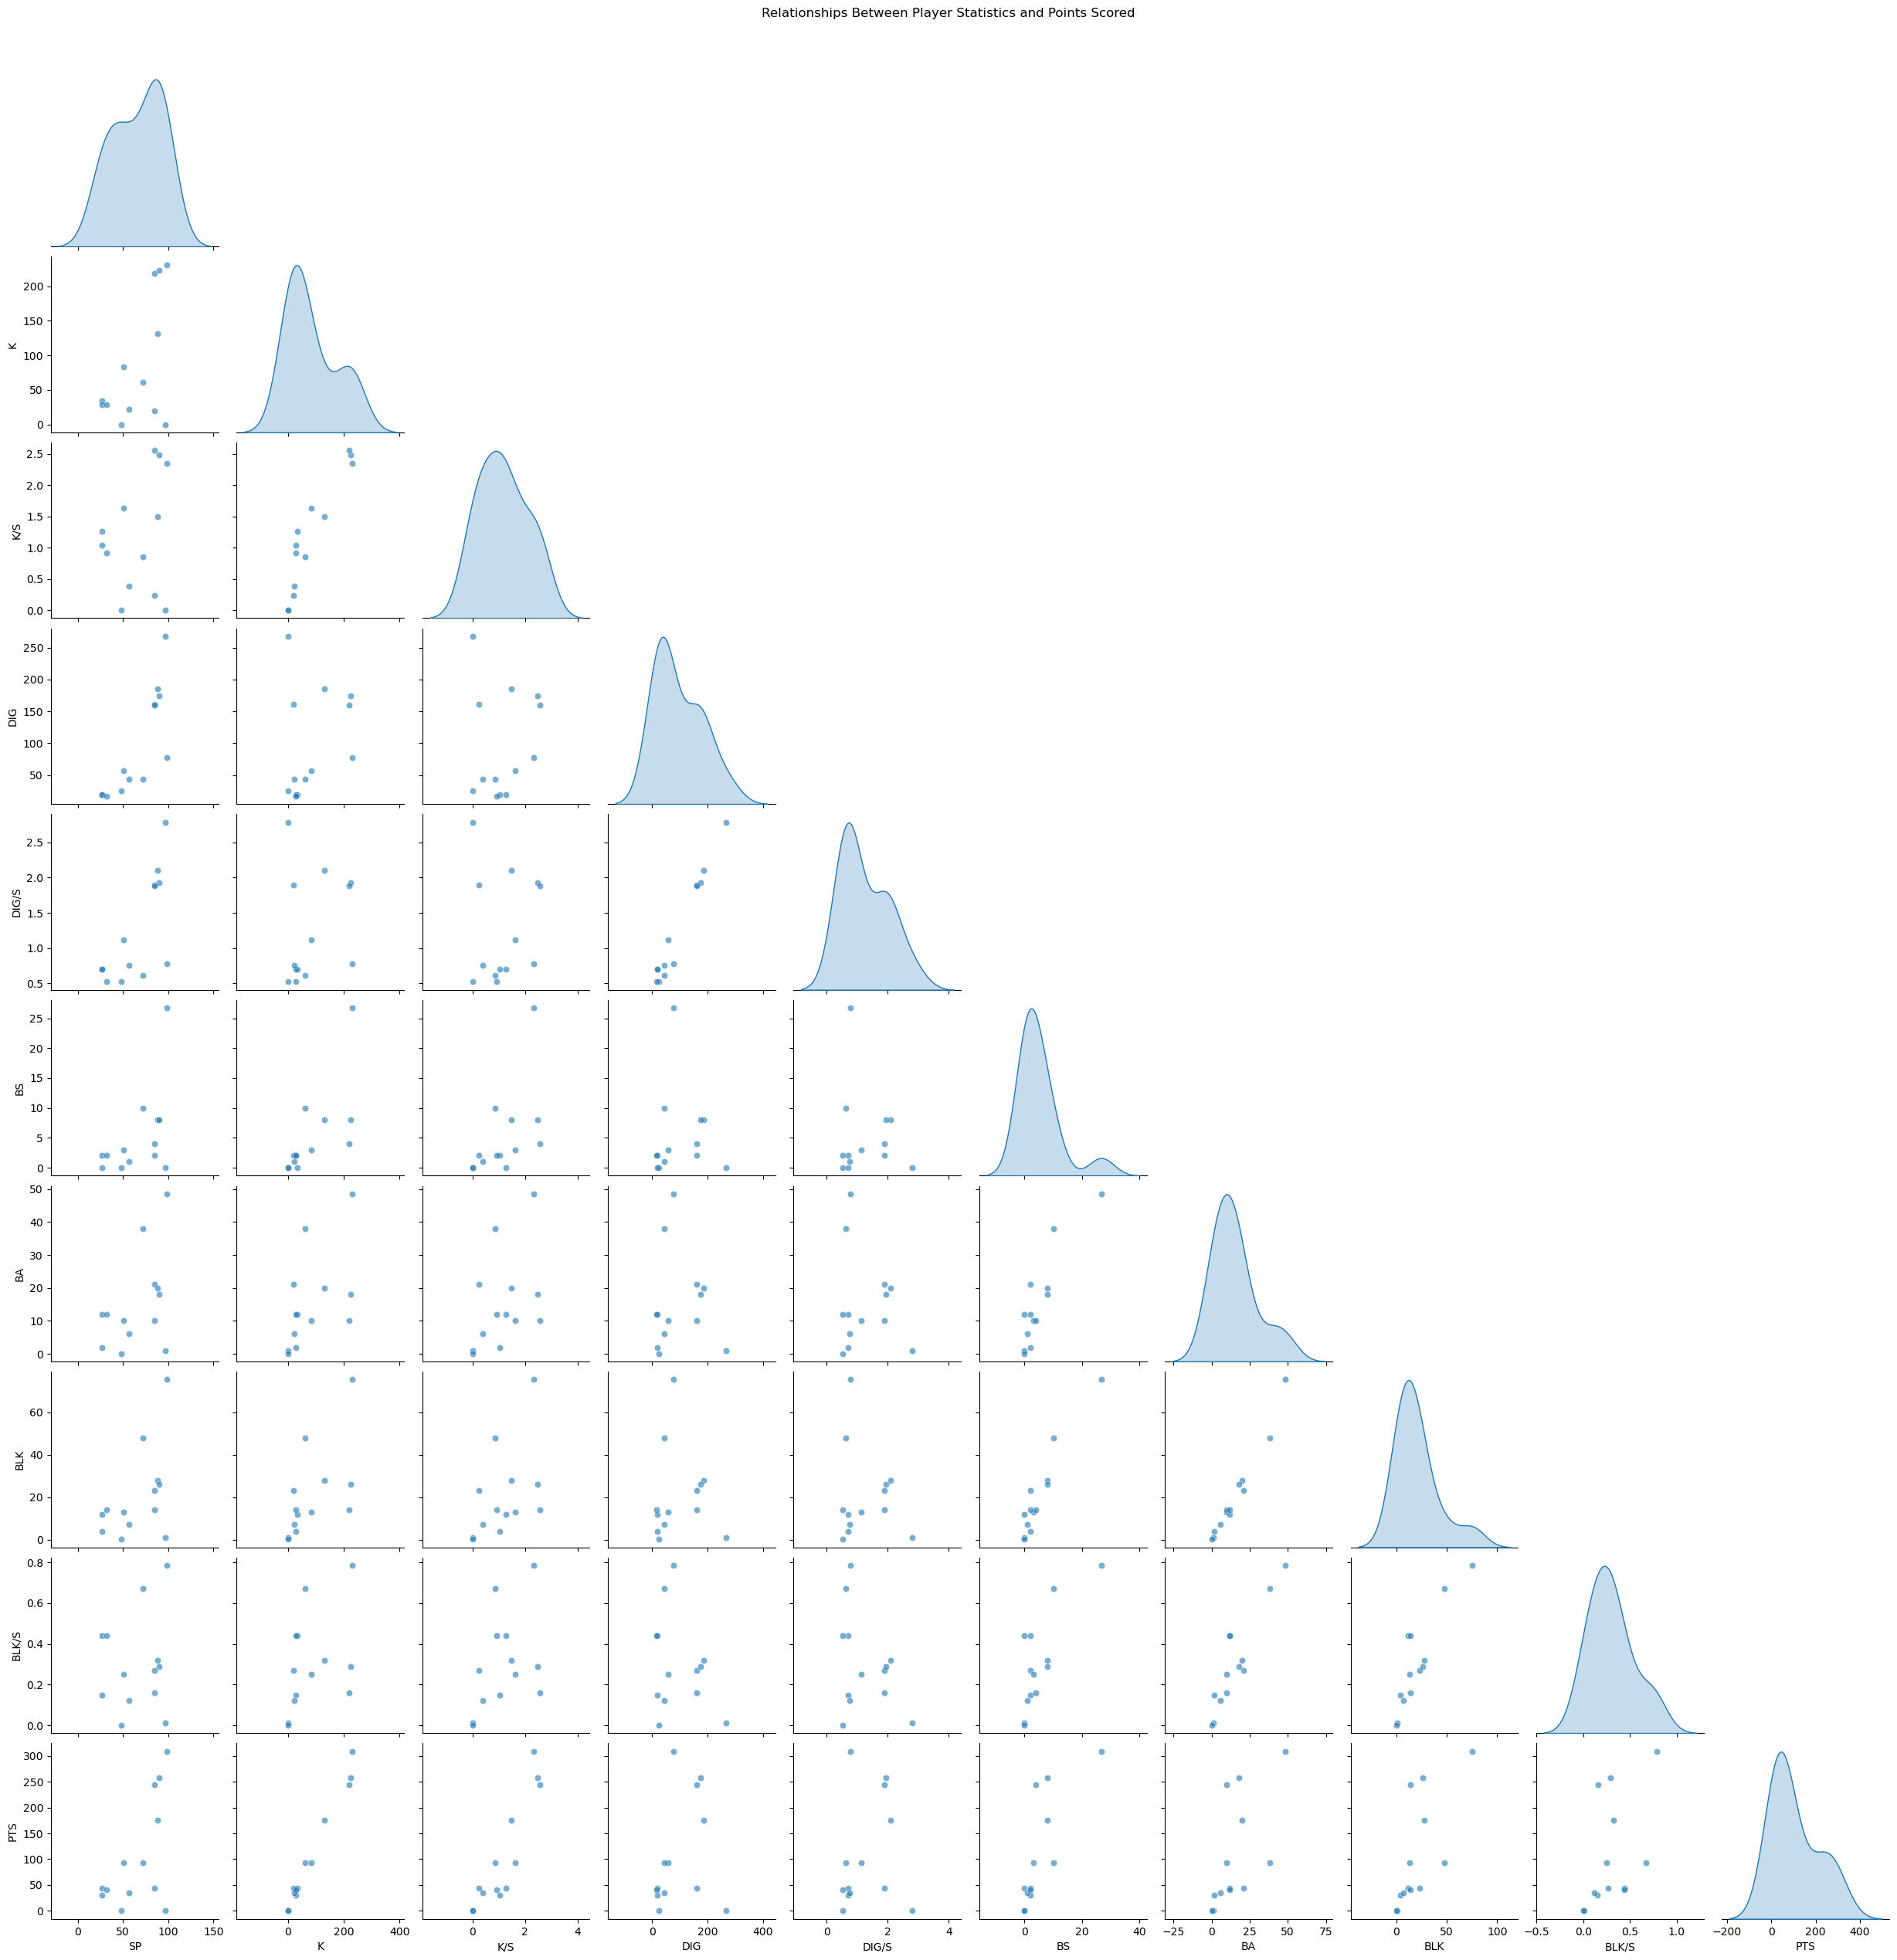

In [14]:
# Scatter matrix of features
sns.pairplot(data_cleaned, diag_kind="kde", corner=True, plot_kws={"alpha": 0.6})
plt.suptitle("Relationships Between Player Statistics and Points Scored", y=1.02)
plt.show()

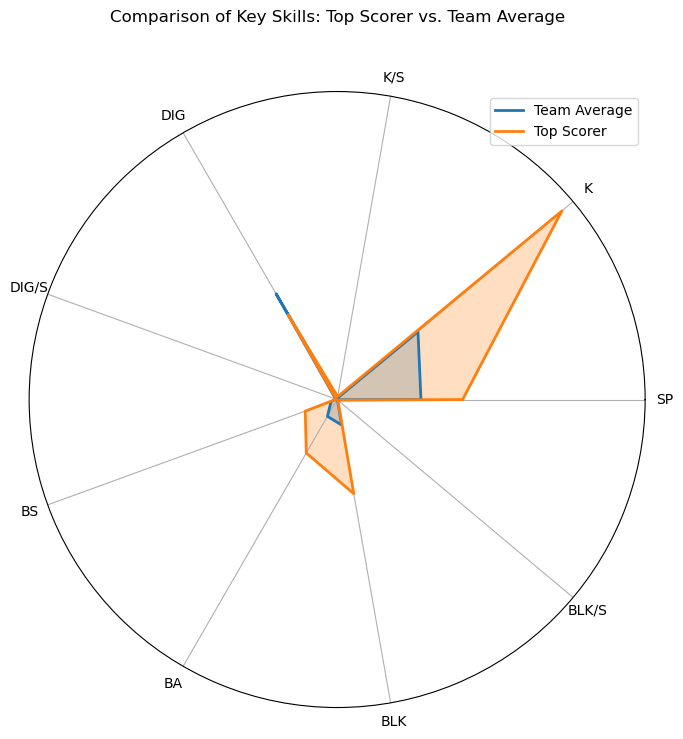

In [15]:
# Radar Chart: Key Skills of a Top Scorer vs. Team Average

team_avg = data_cleaned[features].mean()


top_scorer_idx = data_cleaned['PTS'].idxmax()
top_scorer_stats = data_cleaned.loc[top_scorer_idx, features]

categories = features
num_vars = len(categories)

angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

team_avg_values = team_avg.tolist()
team_avg_values += team_avg_values[:1]

top_scorer_values = top_scorer_stats.tolist()
top_scorer_values += top_scorer_values[:1]

# Create radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.plot(angles, team_avg_values, linewidth=2, linestyle='solid', label="Team Average")
ax.fill(angles, team_avg_values, alpha=0.25)

ax.plot(angles, top_scorer_values, linewidth=2, linestyle='solid', label="Top Scorer")
ax.fill(angles, top_scorer_values, alpha=0.25)

ax.set_yticks([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_title("Comparison of Key Skills: Top Scorer vs. Team Average", y=1.1)
ax.legend(loc="upper right")
plt.show()